<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Investigate_Gapminders_WDI/Investigate_R_and_D_Expenditures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Investigate Gapminder's World Development Indicators

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#questions">Questions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitation">Limitation</a></li>
</ul>

# Introduction <a id='intro'></a>

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

**[Gapminder](https://www.gapminder.org/)** has collected a lot of information about how people live their lives in different countries, tracked across the years, and on a number of different indicators. The complete datasets with hundreds of indicators are available in GitHub repositories, one of which is World Development Indicators (WDI). The data is organized in loose CSV files which can be consumed by any spreadsheet software. More efficient way of consuming data is by using [DDF data model](https://open-numbers.github.io/ddf.html).

DDF is used to define datasets. A dataset is a body of coherent, related data that is composed of separate elements, but can be manipulated as one unit by a computer. Each DDF dataset must have Concepts and may have DataPoints, Entities, Metadata, or Synonyms, whereas:

- **Concepts** contain information about the variables in the data set, i.e. concept properties with simple key (concept = the column-header in a tabular format).
- **DataPoints** contain multidimensional data, i.e. indicators with composite keys (dimensions).
- **Entities** contain single-dimensional data, i.e. entity properties with simple keys (entity).

What datapoints, entities, and concepts to find in what files is defined in the schema and resources sections of a `datapackage.json` file. This is the entry point for any machine that wants to explore the data set:

In [1]:
# Import dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set path to data repozitory
path = 'https://raw.githubusercontent.com/open-numbers/ddf--open_numbers--world_development_indicators/master/'
# Read datapackage.json with data descriptions
datapkg = requests.get(path + 'datapackage.json').json()

# Print key information about a data set
for k,v in datapkg.items():
  if type(v) == str or len(v) < 3:
    print(k, ' :\t', v)
  else:
    print(k, ' : section contains ', len(v), 'elements.')

name  :	 ddf--gapminder--world_development_indicators
language  :	 {'name': 'English', 'id': 'en'}
title  :	 Gapminder's World Development Indicators
description  :	 Gapminder's World Development Indicators
author  :	 Gapminder
license  :	 MIT
created  :	 2021-08-22T12:15:33.269367+00:00
translations  :	 []
version  :	 0.0.1
resources  : section contains  2402 elements.
ddfSchema  : section contains  4 elements.


This data analysis investigates two dependent variables (indicators):
- **Research and development expenditure (% of GDP)**
- **GDP growth (annual %)**

Key description of Research and development expenditure (concept `gb_xpd_rsdv_gd_zs`) and GDP growth (`ny_gdp_mktp_kd_zg`) is provided by `ddf--concepts--continuous.csv` file:

In [3]:
# Load descriptions of continuous concepts
wdic_cont = pd.read_csv(path + 'ddf--concepts--continuous.csv', index_col='concept')

# Define indicators for further analysis
indicators = ['gb_xpd_rsdv_gd_zs', 'ny_gdp_mktp_kd_zg']

# Print key information about indicators
import textwrap # ensures more readable text rendering in ipynb, html, as well as pdf
for i in indicators:
  print('\nConcept:', i)
  print('==========================')
  for v in ['name', 'long_definition', 'statistical_concept_and_methodology', 'source']:
    text = v.replace('_', ' ').capitalize() + ' : ' + wdic_cont.at[i,v]
    for line in textwrap.wrap(text, width=80):
      print(line.replace('\\n', '\n'))
    print()



Concept: gb_xpd_rsdv_gd_zs
Name : Research and development expenditure (% of GDP)

Long definition : Gross domestic expenditures on research and development (R&D),
expressed as a percent of GDP. They include both capital and current
expenditures in the four main sectors: Business enterprise, Government, Higher
education and Private non-profit. R&D covers basic research, applied research,
and experimental development.

Statistical concept and methodology : The gross domestic expenditure on R&D
indicator consists of the total expenditure (current and capital) on R&D by all
resident companies, research institutes, university and government laboratories,
etc. It excludes R&D expenditures financed by domestic firms but performed
abroad. 

The OECD's Frascati Manual defines research and experimental
development as "creative work undertaken on a systemic basis in order to
increase the stock of knowledge, including knowledge of man, culture and
society, and the use of this stock of knowledge 

# Questions <a id='questions'></a>
According to [this data story](https://www.weforum.org/agenda/2020/11/countries-spending-research-development-gdp/), investment in research and development is the lifeblood of many private sector organizations, helping bring new products and services to market. It's also important to national economies and plays a crutial role in GDP growth.

1. Which countries invest haviest in R&D? How stable is their R&D spending as a percentage of GDP? Are there differences between regions or income groups?
2. Is there a correlation between R&D expenditures and GDP growth?


# Data Wrangling <a id='wrangling'></a>

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

An advantage of using a data repozitory organized according to DDF data model is easy loading of clean data. For example, missing data are avoided by 'inner' method of datapoints concatenation. The steps taken to load and check data for analysis are decribed by inline comments in the next cell. Key information about data wrangling privides a log in the next cell's output.

In [4]:
def get_datapoint(path, indicator, dim = 'geo--time'):
  """Reads a datapoint for a given indicator and dimensions.

  Args:
    path : A path to Gapminder World Development Indicator repository.
    indicator : A concept name of an indicator.
    dim : Required dimensions separeted by '--'.

  Returns:
    A pandas.DataFrame indexed by dimensions (or prints non-existent path).
  """

  # Compile the path to CSV file
  path = path + 'datapoints/ddf--datapoints--' + indicator + '--by--' + dim + '.csv'
  index_col = dim.split('--')
  # Either a read csv file or print the incorrect path to check
  try:
    df = pd.read_csv(path, index_col=index_col)
    print(f'Loading {indicator} ...')
    print('Shape: ', df.shape)
    print('===== Head of a DataFrame ====')
    print(df.head(), '\n==============================\n')
    return df
  except:
    print(f'No such file at path\n{path}')
    return None


# Load research and development data
df_rad_exp = get_datapoint(path, 'gb_xpd_rsdv_gd_zs')

# Load GDP growth data
df_gdp_gr = get_datapoint(path, 'ny_gdp_mktp_kd_zg')

# Concatenate R&D data with GDP growth data where both values are available
df = pd.concat([df_rad_exp, df_gdp_gr], axis=1, join='inner').reset_index()

# Shorten names of indicators
df.rename(columns={'ny_gdp_mktp_kd_zg': 'gdp_gr', 'gb_xpd_rsdv_gd_zs': 'rad_exp'}, inplace=True)

# Load country data
countries = pd.read_csv(path + 'ddf--entities--geo--country.csv', index_col='country')

# Add country data into the dataframe
for col in ['name', 'income_groups', 'world_4region']:
  df[col] = df.geo.apply(lambda c: countries.at[c, col])

# Check duplicates and missing values
assert df.duplicated().sum() == 0
print('No duplicated observations.')
assert df.isna().any().any() == False
print('No missing values.')
print('Shape after concatenation and extension :', df.shape)
print('Resulting data set including country data:')
df.head()

Loading gb_xpd_rsdv_gd_zs ...
Shape:  (1527, 1)
===== Head of a DataFrame ====
          gb_xpd_rsdv_gd_zs
geo time                   
alb 2007            0.08737
    2008            0.15412
are 2011            0.48920
    2014            0.70000
arg 1996            0.41749 

Loading ny_gdp_mktp_kd_zg ...
Shape:  (9595, 1)
===== Head of a DataFrame ====
          ny_gdp_mktp_kd_zg
geo time                   
abw 1987           16.07843
    1988           18.64865
    1989           12.12984
    1990            3.96140
    1991            7.96287 

No duplicated observations.
No missing values.
Shape after concatenation and extension : (1524, 7)
Resulting data set including country data:


,geo,time,rad_exp,gdp_gr,name,income_groups,world_4region
0,alb,2007,0.08737,5.97998,Albania,upper_middle_income,europe
1,alb,2008,0.15412,7.49997,Albania,upper_middle_income,europe
2,are,2011,0.48920,6.93027,United Arab Emirates,high_income,asia
3,are,2014,0.70000,4.28430,United Arab Emirates,high_income,asia
4,arg,1996,0.41749,5.52669,Argentina,upper_middle_income,americas


> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

This analysis focuses on R&D expenditures. The Gapminder WDI data set contains 1.527 observations of this indicator. There are many more observations of GDP growth (9.595) but 'inner' method of concatenation ensures that in resulting dataframe there are only those observation with both values of R&D expenditure and GDP growth. There are 1524 of such combined observation available for further exploration.


In [8]:
def count_missing(df):
  """Counts number of missing observations for dimensions `geo` and `time`
  and prints `rad_exp` statistics."""

  if {'geo', 'time', 'rad_exp'}.issubset(set(df.columns)):
    n_geo = df.geo.nunique()
    n_time = df.time.nunique()
    df_len = df.shape[0]
    print(f"There are {df_len} observations for {n_geo} countries and {n_time} years.")
    print(f"It means that there are missing {1-df_len/(n_geo*n_time):.2%} out of {n_geo*n_time} possible observations.")
    print('\nCheck statistics of rad_exp:')
    print(df.rad_exp.describe())
    return
  else:
    print('Function not applicable for this dataset')
    return
  
count_missing(df)

There are 1524 observations for 136 countries and 19 years.
It means that there are missing 41.02% out of 2584 possible observations.
count    1524.000000
mean        0.945200
std         0.932892
min         0.005440
25%         0.245505
50%         0.596610
75%         1.342307
max         4.407440
Name: rad_exp, dtype: float64


The next histogram shows the number of observations for individual countries:



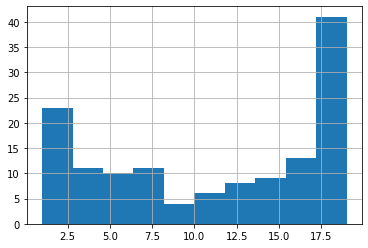

In [9]:
# Group countries and count number of observations
geo_observation_counts = df.groupby('geo')['time'].count()
geo_observation_counts.hist();

To ensure better comprehensiveness of results, we take only countries with at least 10 observations out of 19 for further examination:

In [10]:
# Take a subset of countries with more than 9 observations
geo_subset = geo_observation_counts[geo_observation_counts > 9].index
df = df.loc[df.geo.apply(lambda g: g in geo_subset)]

count_missing(df)

There are 1276 observations for 77 countries and 19 years.
It means that there are missing 12.78% out of 1463 possible observations.
count    1276.000000
mean        1.068332
std         0.954212
min         0.015620
25%         0.340865
50%         0.720835
75%         1.643235
max         4.407440
Name: rad_exp, dtype: float64


The new dataframe contains more complete data as the percentage of missing values decreased from 41% to 13%.

In [11]:
# Count unique values of discrete variables
df.iloc[:, [0,1,5,6]].nunique()

geo              77
time             19
income_groups     4
world_4region     4
dtype: int64


Categorizations into 4 income groups and 4 world regions are other variables related to country's economy and location for some group-wise analysis:

In [12]:
df.income_groups.unique(), df.world_4region.unique()

(array(['upper_middle_income', 'high_income', 'low_income',
        'lower_middle_income'], dtype=object),
 array(['americas', 'europe', 'asia', 'africa'], dtype=object))

# Exploratory Data Analysis <a id='eda'></a>

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

## Research and Development Expenditure
- Which countries invest most and which least in R&D?
- How stable is their R&D spending as a percentage of GDP? 
- Are there differences between regions or income groups?

In [13]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


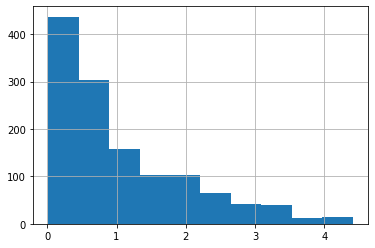

In [14]:
# Plot a histogram
df.rad_exp.hist();

In [15]:
rank = df.groupby('name')['rad_exp'].mean().sort_values(ascending=False)
rank

name
Israel                    3.840534
Sweden                    3.397525
Finland                   3.252687
Japan                     3.212692
South Korea               2.892914
                            ...   
Kuwait                    0.146299
Bosnia and Herzegovina    0.100748
Tajikistan                0.089615
Trinidad and Tobago       0.085095
Macao, China              0.066441
Name: rad_exp, Length: 77, dtype: float64

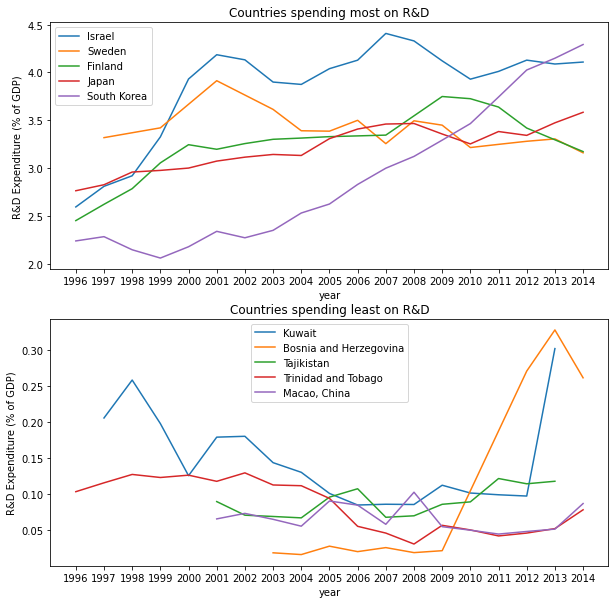

In [16]:
rad_country_rank = [['Countries spending most on R&D', rank.head().index], ['Countries spending least on R&D', rank.tail().index]]
fig, ax =  plt.subplots(2, 1, sharex=False, figsize=(10, 10))
for i in [0, 1]:
  for name in rad_country_rank[i][1]:
    ax[i].plot(df.loc[df['name'] == name, ['time', 'rad_exp']].set_index('time'), label=name)
  ax[i].set_xticks(range(df.time.min(), df.time.max()+1))
  ax[i].set_xlabel('year')
  ax[i].set_ylabel('R&D Expenditure (% of GDP)')
  ax[i].set_title(rad_country_rank[i][0])
  ax[i].legend()
plt.show()

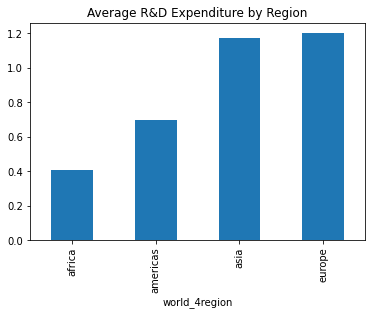

In [28]:
# Differences between regions
df.groupby('world_4region')['rad_exp'].mean().sort_values().plot(kind='bar', title='Average R&D Expenditure by Region');

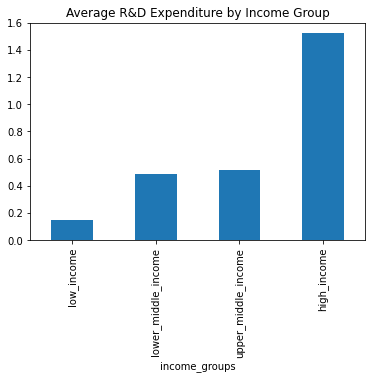

In [29]:
# Diffeences between income groups
df.groupby('income_groups')['rad_exp'].mean().sort_values().plot(kind='bar', title='Average R&D Expenditure by Income Group');

In [22]:
df.columns

Index(['geo', 'time', 'rad_exp', 'gdp_gr', 'name', 'income_groups',
       'world_4region'],
      dtype='object')

## Role of R&D in GDP Growth
- Is there a correlation between R&D expenditures and GDP growth?

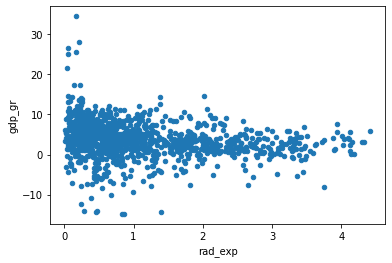

In [23]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
df.plot(x='rad_exp', y='gdp_gr', kind='scatter');

In [24]:
df.loc[(df.rad_exp < 1) & (df.gdp_gr > 15)]

,geo,time,rad_exp,gdp_gr,name,income_groups,world_4region
79,aze,2005,0.21994,27.96154,Azerbaijan,upper_middle_income,europe
80,aze,2006,0.17165,34.46621,Azerbaijan,upper_middle_income,europe
81,aze,2007,0.17006,25.46322,Azerbaijan,upper_middle_income,europe
814,kwt,2003,0.14347,17.32602,Kuwait,high_income,asia
894,mac,2004,0.05545,26.63067,"Macao, China",high_income,asia
900,mac,2010,0.04991,25.12292,"Macao, China",high_income,asia
901,mac,2011,0.04453,21.61647,"Macao, China",high_income,asia
1021,mng,2011,0.23054,17.29078,Mongolia,lower_middle_income,asia


In [26]:
df.query('rad_exp < 1 and gdp_gr > 15')

,geo,time,rad_exp,gdp_gr,name,income_groups,world_4region
79,aze,2005,0.21994,27.96154,Azerbaijan,upper_middle_income,europe
80,aze,2006,0.17165,34.46621,Azerbaijan,upper_middle_income,europe
81,aze,2007,0.17006,25.46322,Azerbaijan,upper_middle_income,europe
814,kwt,2003,0.14347,17.32602,Kuwait,high_income,asia
894,mac,2004,0.05545,26.63067,"Macao, China",high_income,asia
900,mac,2010,0.04991,25.12292,"Macao, China",high_income,asia
901,mac,2011,0.04453,21.61647,"Macao, China",high_income,asia
1021,mng,2011,0.23054,17.29078,Mongolia,lower_middle_income,asia


# Conclusions <a id='conclusions'></a>

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!

# Limitation <a id='limitation'></a>
